In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter


import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy
import pyarrow

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pymc3 as pm

import patch
import kinematics

In [2]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [4]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Time in Patch: Simple Linear Regression

In [23]:
def AddRegressors(Visits_Patch1, Visits_Patch2):
        Visits_Patch1 = Visits_Patch1.copy()
        Visits_Patch2 = Visits_Patch2.copy()

        Visits_Patch1['DistanceTravelledinVisit'] = 0
        for i in range(len(Visits_Patch1)):
                start, end = Visits_Patch1.start[i], Visits_Patch1.end[i]
                
                encoder1 = api.load(root, exp02.Patch1.Encoder, start=start, end=end)
                '''                
                if encoder1.empty: Visits_Patch1.loc[i, 'DistanceTravelledinVisit'] = 0
                else:
                        w1 = -distancetravelled(encoder1.angle)
                        Visits_Patch1.loc[i, 'DistanceTravelledinVisit'] = w1[0]-w1[-1]'''
                if not encoder1.empty: 
                        w1 = -distancetravelled(encoder1.angle)
                        Visits_Patch1.loc[i, 'DistanceTravelledinVisit'] = w1[0]-w1[-1]
        
        Visits_Patch1['PelletsInLastVisitSelf'] = 0
        Visits_Patch1['PelletsInLastVisitOther'] = 0
        for i in range(1,len(Visits_Patch1)):
                start, end = Visits_Patch1.start[i-1], Visits_Patch1.end[i-1]
                
                pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
                Visits_Patch1.loc[i, 'PelletsInLastVisitSelf'] = len(pellets_patch1)
                
                prior_timestamps = Visits_Patch2[Visits_Patch2['end'] < Visits_Patch1.start[i]]
                '''if prior_timestamps.empty: Visits_Patch1.loc[i, 'PelletsInLastVisitOther'] = 0
                else:'''
                if not prior_timestamps.empty:
                        start_, end_ = prior_timestamps.iloc[-1]['start'], prior_timestamps.iloc[-1]['end']
                        pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start_, end=end_)
                        Visits_Patch1.loc[i, 'PelletsInLastVisitOther'] = len(pellets_patch2)
                
        Visits_Patch2['DistanceTravelledinVisit'] = 0
        for i in range(len(Visits_Patch2)):
                start, end = Visits_Patch2.start[i], Visits_Patch2.end[i]
                encoder2 = api.load(root, exp02.Patch2.Encoder, start=start, end=end)
                '''                
                if encoder2.empty: Visits_Patch2.loc[i, 'DistanceTravelledinVisit'] = 0
                else:
                        w2 = -distancetravelled(encoder2.angle)
                        Visits_Patch2.loc[i, 'DistanceTravelledinVisit'] = w2[0]-w2[-1]'''
                if not encoder2.empty:
                        w2 = -distancetravelled(encoder2.angle)
                        Visits_Patch2.loc[i, 'DistanceTravelledinVisit'] = w2[0]-w2[-1]
        
                
        Visits_Patch2['PelletsInLastVisitSelf'] = 0
        Visits_Patch2['PelletsInLastVisitOther'] = 0
        for i in range(1,len(Visits_Patch2)):
                start, end = Visits_Patch2.start[i-1], Visits_Patch2.end[i-1]

                pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
                Visits_Patch2.loc[i, 'PelletsInLastVisitSelf'] = len(pellets_patch2)
                
                prior_timestamps = Visits_Patch1[Visits_Patch1['end'] < Visits_Patch2.start[i]]
                '''if prior_timestamps.empty: Visits_Patch2.loc[i, 'PelletsInLastVisitOther'] = 0
                else:
                        start_, end_ = prior_timestamps.iloc[-1]['start'], prior_timestamps.iloc[-1]['end']
                        pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start_, end=end_)
                        Visits_Patch2.loc[i, 'PelletsInLastVisitOther'] = len(pellets_patch1)'''
                if not prior_timestamps.empty: 
                        start_, end_ = prior_timestamps.iloc[-1]['start'], prior_timestamps.iloc[-1]['end']
                        pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start_, end=end_)
                        Visits_Patch2.loc[i, 'PelletsInLastVisitOther'] = len(pellets_patch1)

        return Visits_Patch1, Visits_Patch2

ShortSession0


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:148: UserWarning: data index for Patch1_90_* contains duplicate keys!
  warnings.warn(f"data index for {reader.pattern} contains duplicate keys!")
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:148: UserWarning: data index for Patch1_90_* contains duplicate keys!
  warnings.warn(f"data index for {reader.pattern} contains duplicate keys!")
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:148: UserWarning: data index for Patch1_90_* contains duplicate keys!
  warnings.warn(f"data index for {reader.pattern} contains duplicate keys!")
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:148: UserWarning: data index for Patch1_90_* contains duplicate keys!
  warnings.warn(f"data index for {reader.pattern} contains duplicate keys!")
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:148: UserWarning: data index for Patch1_90_* contains duplicate keys!
  warnings.warn(f"data index for {reader.p

ShortSession1
ShortSession2
ShortSession3
ShortSession4
ShortSession5
ShortSession6
ShortSession7
ShortSession8
ShortSession9
ShortSession10
ShortSession11
MSE: 234947.58610183262, R-squared: 0.6250240596248251
Correlation: 0.790584631538473


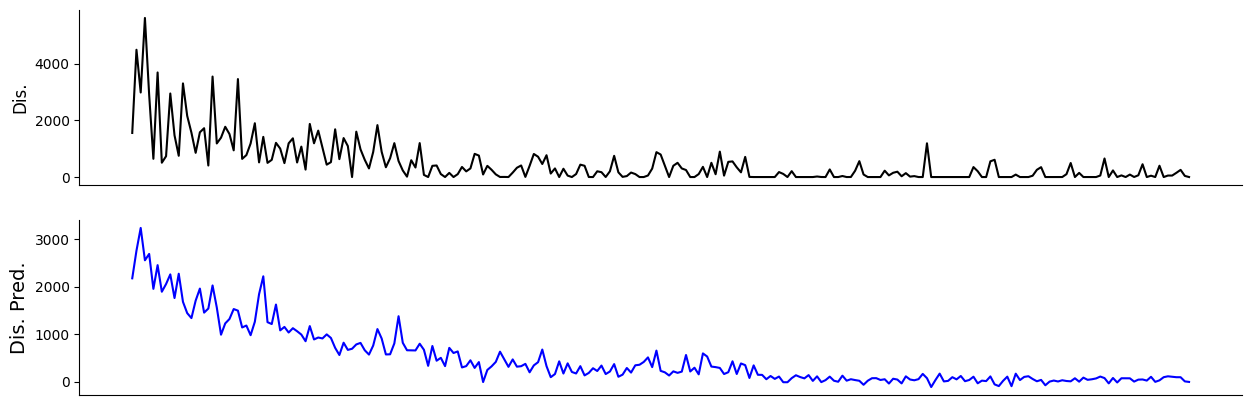

In [24]:
dfs = []
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)

    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    
    Visits_Patch1 = patch.VisitPatch(mouse_pos, patch = 'Patch1', speed_ave_time = '5S', acce_ave_time = '5S', weight_ave_time = '5S')
    Visits_Patch2 = patch.VisitPatch(mouse_pos, patch='Patch2',speed_ave_time = '5S', acce_ave_time = '5S', weight_ave_time = '5S')
    Visits_Patch1, Visits_Patch2 = AddRegressors(Visits_Patch1, Visits_Patch2) 
    Visits_Patch1 = Visits_Patch1.loc[:,['speed','acceleration', 'weight','PelletsInLastVisitSelf', 'PelletsInLastVisitOther', 'DistanceTravelledinVisit']]
    Visits_Patch2 = Visits_Patch2.loc[:,['speed','acceleration', 'weight','PelletsInLastVisitSelf', 'PelletsInLastVisitOther', 'DistanceTravelledinVisit']]
    dfs.append(Visits_Patch1)
    dfs.append(Visits_Patch2)
    
VISIT = dfs[0]
for df in dfs[1:]: VISIT = VISIT.add(df, fill_value=0)   
    
X = VISIT[['speed','acceleration', 'weight','PelletsInLastVisitSelf', 'PelletsInLastVisitOther']]
Y = VISIT['DistanceTravelledinVisit']

    
coefficients, intercept, y_pred, mse, r2 = patch.SimpleLinearRegression(X, Y)
print(f"MSE: {mse}, R-squared: {r2}")
print(f"Correlation: {np.corrcoef(Y, y_pred)[0,1]}")

        
fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

axs[0].plot(Y, color = 'black')
axs[0].set_xticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_ylabel('Dis.', fontsize = 12)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].plot(y_pred, color = 'blue')
axs[1].set_xticks([]) 
axs[1].set_facecolor('white') 
axs[1].set_ylabel('Dis. Pred.', fontsize = 14)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

plt.show()

In [31]:
X.iloc[index]

,speed,acceleration,weight,PelletsInLastVisitSelf,PelletsInLastVisitOther
135,344.555481,4400.381384,79.351707,2.0,13.0
28,1698.011856,14067.091509,399.197073,8.0,0.0
46,1860.185404,11178.752932,311.447441,16.0,1.0
38,2029.855345,14050.401437,389.696831,15.0,1.0
247,30.711926,634.983399,30.000000,1.0,3.0
...,...,...,...,...,...
7,2926.554228,21923.683981,552.786343,38.0,14.0
99,302.732784,6835.634121,93.421345,16.0,2.0
179,34.807433,574.193302,23.500000,5.0,0.0
230,58.832346,816.448056,28.200001,1.0,2.0


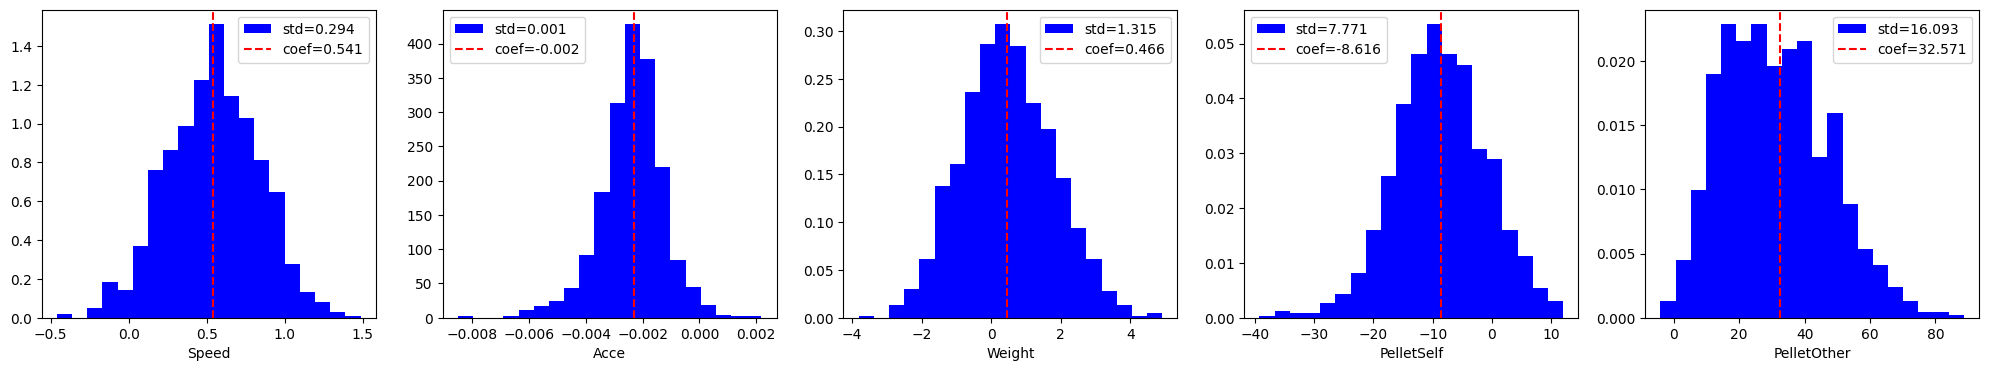

In [32]:
COFF = []
for t in range (1000):
    index = np.random.choice(np.arange(len(Y)), size=len(Y), replace=True)
    coefficients1, intercept1, y1_pred, mse1, r21 = patch.SimpleLinearRegression(X.iloc[index], Y[index])
    COFF.append(coefficients1)
COFF = np.array(COFF)
                
FEATURE = ['Speed', 'Acce', 'Weight', 'PelletSelf', 'PelletOther']
fig, axs = plt.subplots(1,5,figsize = (25,4))
for j in range(5):
    axs[j].hist(COFF.T[j], color = 'blue', bins = 20, density = True, label = 'std='+str(round(np.std(COFF.T[j]), 3)))
    axs[j].axvline(coefficients[j], color = 'red', linestyle = '--', label = 'coef='+str(round(coefficients[j], 3)))
    axs[j].legend()
    axs[j].set_xlabel(FEATURE[j])
#axs[0,0].set_ylabel('Patch 1')
plt.show()

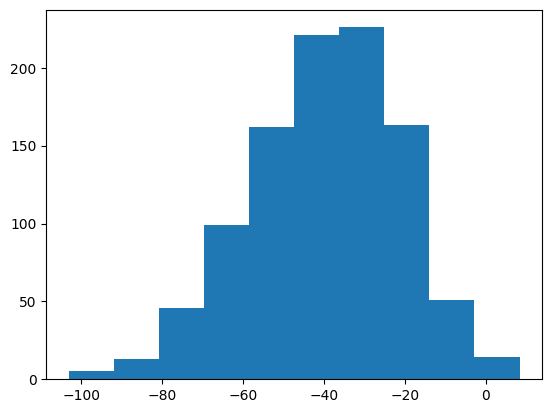

In [33]:
plt.hist(COFF.T[3]-COFF.T[4])
plt.show()